In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [74]:

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x)**2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

In [75]:
def binary_cross_entropy(y_true, y_pred):
    eps = 1e-8
    return - (y_true * np.log(y_pred+eps) + (1 - y_true) * np.log(1 - y_pred+eps))

def mse_loss(y_true, y_pred):
    return 0.5 * (y_pred - y_true)**2

In [76]:
import numpy as np

# Activation Functions
def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x) ** 2  # Derivative of tanh

def sigmoid(x):
    return 1 / (1 + np.exp(-x))  # Sigmoid activation

class NeuralNetwork:
    def __init__(self, input_size=2, h1_size=2, h2_size=3, output_size=1, task='classification', custom_params=None):
        self.task = task  # Either 'classification' or 'regression'

        # If custom parameters are provided, use them; otherwise, initialize randomly
        if custom_params:
            self.params = custom_params
        else:
            self.params = {
                "W1": np.random.randn(input_size, h1_size) * 0.1,
                "b1": np.zeros((1, h1_size)),
                "W2": np.random.randn(h1_size, h2_size) * 0.1,
                "b2": np.zeros((1, h2_size)),
                "W3": np.random.randn(h2_size, output_size) * 0.1,
                "b3": np.zeros((1, output_size))
            }

    def forward(self, X):
        # Layer 1
        Z1 = np.dot(X, self.params["W1"]) + self.params["b1"]
        A1 = tanh(Z1)

        # Layer 2
        Z2 = np.dot(A1, self.params["W2"]) + self.params["b2"]
        A2 = tanh(Z2)

        # Output layer
        Z3 = np.dot(A2, self.params["W3"]) + self.params["b3"]
        if self.task == 'classification':
            A3 = sigmoid(Z3)
        else:
            A3 = Z3  # Linear for regression

        # Cache values for backpropagation
        caches = (X, Z1, A1, Z2, A2, Z3, A3)
        return A3, caches

    def backward(self, y_true, caches):
        # Unpack caches
        X, Z1, A1, Z2, A2, Z3, A3 = caches

        # Output layer delta:
        dZ3 = A3 - y_true  # Shape (batch_size, output_size)
        dW3 = np.dot(A2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Layer 2
        dA2 = np.dot(dZ3, self.params["W3"].T)
        dZ2 = dA2 * dtanh(Z2)
        dW2 = np.dot(A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Layer 1
        dA1 = np.dot(dZ2, self.params["W2"].T)
        dZ1 = dA1 * dtanh(Z1)
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        grads = {"W1": dW1, "b1": db1,
                 "W2": dW2, "b2": db2,
                 "W3": dW3, "b3": db3}
        return grads


# Example: Manually Set Weights and Biases
custom_params = {
    "W1": np.array([[-0.173, -0.100], [-0.26, -0.030]]),  # Shape (2,2)
    "b1": np.array([[0.1, -0.2]]),              # Shape (1,2)
    "W2": np.array([[-0.08, -0.12, 0.08], [0.04, -0.04, 0.07]]),  # Shape (2,3)
    "b2": np.array([[0.05, -0.04, 0.02]]),                 # Shape (1,3)
    "W3": np.array([[0.3], [-0.5], [0.7]]),  # Shape (3,1)
    "b3": np.array([[0.05]])                 # Shape (1,1)
}

# Create Neural Network with Custom Weights
nn = NeuralNetwork(input_size=2, h1_size=2, h2_size=3, output_size=1, custom_params=custom_params)

# Print to Verify
print("W1:\n", nn.params["W1"])
print("b1:\n", nn.params["b1"])
print("W2:\n", nn.params["W2"])
print("b2:\n", nn.params["b2"])
print("W3:\n", nn.params["W3"])
print("b3:\n", nn.params["b3"])



W1:
 [[-0.173 -0.1  ]
 [-0.26  -0.03 ]]
b1:
 [[ 0.1 -0.2]]
W2:
 [[-0.08 -0.12  0.08]
 [ 0.04 -0.04  0.07]]
b2:
 [[ 0.05 -0.04  0.02]]
W3:
 [[ 0.3]
 [-0.5]
 [ 0.7]]
b3:
 [[0.05]]


In [77]:
def update_parameters(params, grads, optimizer, states, lr, t):
    # For each parameter, update using the chosen optimization method.
    # 'states' is a dictionary that holds optimizer-specific state (like momentum, RMSprop accumulators, etc.)
    for key in params.keys():
        grad = grads[key]
        # SGD (plain)
        if optimizer == 'SGD':
            params[key] = params[key] - lr * grad

        # Momentum
        elif optimizer == 'Momentum':
            if key not in states:
                states[key] = {"v": np.zeros_like(grad)}
            momentum_coeff = 0.9
            states[key]["v"] = momentum_coeff * states[key]["v"] - lr * grad
            params[key] = params[key] + states[key]["v"]

        # RMSprop
        elif optimizer == 'RMSprop':
            if key not in states:
                states[key] = {"s": np.zeros_like(grad)}
            decay = 0.9
            eps = 1e-8
            states[key]["s"] = decay * states[key]["s"] + (1 - decay) * (grad**2)
            params[key] = params[key] - lr * grad / (np.sqrt(states[key]["s"]) + eps)

        # Adam
        elif optimizer == 'Adam':
            if key not in states:
                states[key] = {"m": np.zeros_like(grad), "v": np.zeros_like(grad)}
            beta1 = 0.9
            beta2 = 0.999
            eps = 1e-8
            states[key]["m"] = beta1 * states[key]["m"] + (1-beta1)*grad
            states[key]["v"] = beta2 * states[key]["v"] + (1-beta2)*(grad**2)
            # Bias correction
            m_corr = states[key]["m"] / (1 - beta1**(t+1))
            v_corr = states[key]["v"] / (1 - beta2**(t+1))
            params[key] = params[key] - lr * m_corr / (np.sqrt(v_corr) + eps)

        # Adagrad
        elif optimizer == 'Adagrad':
            if key not in states:
                states[key] = {"r": np.zeros_like(grad)}
            eps = 1e-8
            states[key]["r"] = states[key]["r"] + grad**2
            params[key] = params[key] - lr * grad / (np.sqrt(states[key]["r"]) + eps)

        else:
            raise ValueError("Unknown optimizer: " + optimizer)
    return params, states

In [78]:

def generate_synthetic_data(task='classification', n_samples=200):
    np.random.seed(42)
    if task == 'classification':
        # Create a simple binary classification problem: two classes from two Gaussian clusters.
        X = np.random.randn(n_samples, 2)
        # Label by a simple linear boundary: if x0 + x1 > 0 then class 1, else 0.
        y = (X[:,0] + X[:,1] > 0).astype(np.float32)
        y = y.reshape(-1, 1)
    else:
        # For regression: Let y be a simple non-linear function of the two inputs.
        X = np.random.uniform(-1, 1, (n_samples, 2))
        y = (np.sin(np.pi * X[:,0]) + np.cos(np.pi * X[:,1])).reshape(-1, 1)
    return X, y

In [79]:
def train_network(task='classification', optimizer='SGD', epochs=180, lr=0.01):
    # Generate synthetic data
    X, y = generate_synthetic_data(task=task, n_samples=200)
    n_samples = X.shape[0]

    # Create our neural network (from scratch)
    nn = NeuralNetwork(input_size=2, h1_size=2, h2_size=3, output_size=1, task=task)

    # To hold optimizer state (for momentum, RMSprop, etc.)
    opt_states = {}

    # To record parameter history and loss for plotting later
    history = {
        "loss": [],
        "W1": [],
        "b1": [], 
        "W2": [],
        "b2": [],
        "W3": [],
        "b3": []
    }

    # For each epoch (here each update is a single-sample update)
    for t in range(epochs):
        # Sample one data point (SGD update)
        idx = np.random.randint(0, n_samples)
        X_sample = X[idx:idx+1]  # shape (1,2)
        y_sample = y[idx:idx+1]  # shape (1,1)

        # Forward pass
        y_pred, caches = nn.forward(X_sample)

        # Compute loss
        if task == 'classification':
            loss = binary_cross_entropy(y_sample, y_pred)
        else:
            loss = mse_loss(y_sample, y_pred)
        history["loss"].append(loss.item())

        # Backward pass
        grads = nn.backward(y_sample, caches)

        # Update parameters using the chosen optimizer
        nn.params, opt_states = update_parameters(nn.params, grads, optimizer, opt_states, lr, t)

        # Record current parameters (we flatten each parameter array for plotting)
        for key in ["W1", "b1", "W2", "b2", "W3", "b3"]:
            history[key].append(nn.params[key].copy())

    # After training, return history and final parameters along with the synthetic data (for possible later evaluation)
    return history, nn.params, X, y

In [80]:
def plot_loss(history, optimizer, task):
    plt.figure(figsize=(6,4))
    plt.plot(history["loss"])
    plt.title(f'Loss vs Iterations ({task.capitalize()} - {optimizer})')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

In [81]:

def plot_parameter_histories(history, optimizer, task):
    # For each parameter group, plot the evolution of each element.
    param_keys = ["W1", "b1", "W2", "b2", "W3", "b3"]
    for key in param_keys:
        param_history = history[key]
        # Convert list of arrays to a 2D array: (epochs, num_parameters)
        # We flatten each parameter matrix/vector into a 1D array.
        flattened = np.array([p.flatten() for p in param_history])
        n_params = flattened.shape[1]
        plt.figure(figsize=(6,4))
        for i in range(n_params):
            plt.plot(flattened[:, i], label=f"{key}_{i}")
        plt.title(f'Parameter evolution for {key} ({optimizer}, {task})')
        plt.xlabel("Iterations")
        plt.ylabel("Parameter value")
        plt.legend(fontsize=8)
        plt.grid(True)
        plt.show()
        
        
def display_parameter_table(history, iteration_indices):
    # Display a table (DataFrame) of parameter values at selected iterations
    data = []
    for i in iteration_indices:
        row = {"Iteration": i}
        for key in ["W1", "b1", "W2", "b2", "W3", "b3"]:
            # Flatten the parameter array and convert to list
            row[key] = np.around(history[key][i].flatten(), decimals=3).tolist()
        row["Loss"] = np.around(history["loss"][i], decimals=4)
        data.append(row)
    df = pd.DataFrame(data)
    return df        

=== Classification Task ===

Training with SGD optimizer (Classification)...


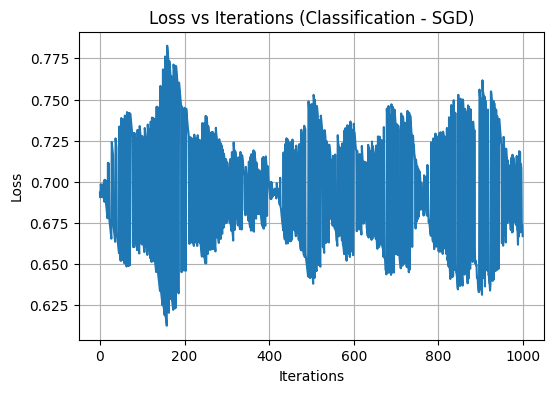

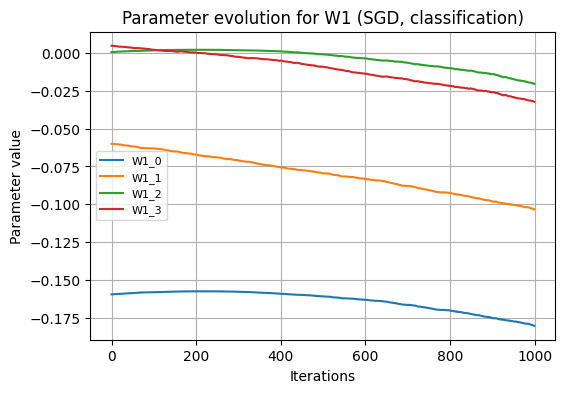

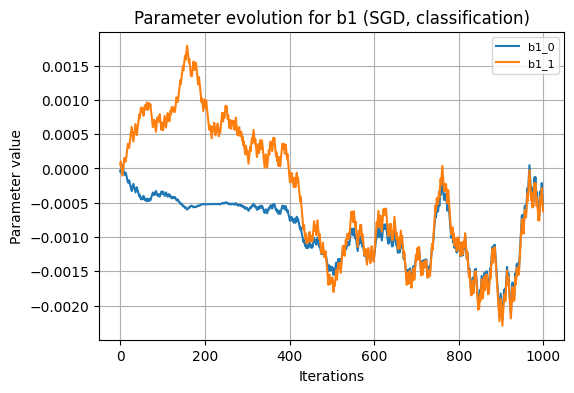

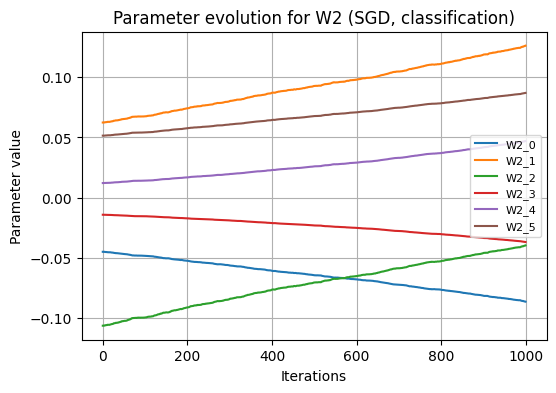

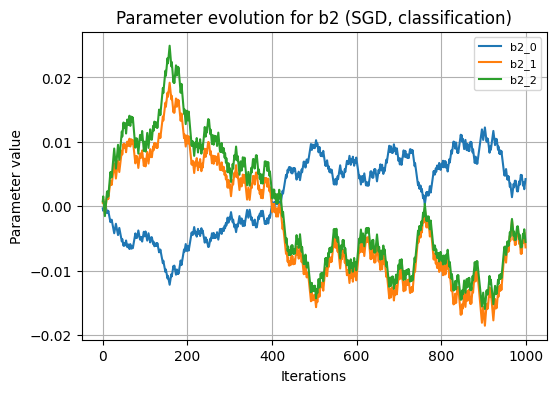

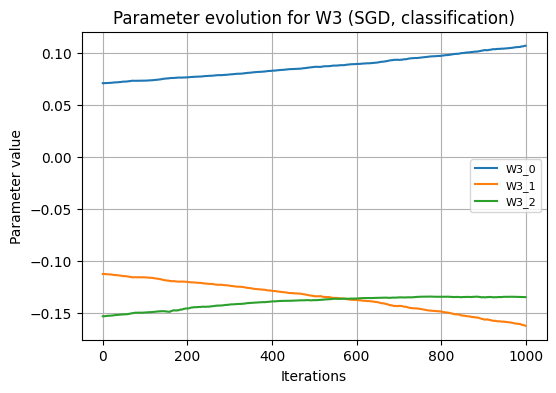

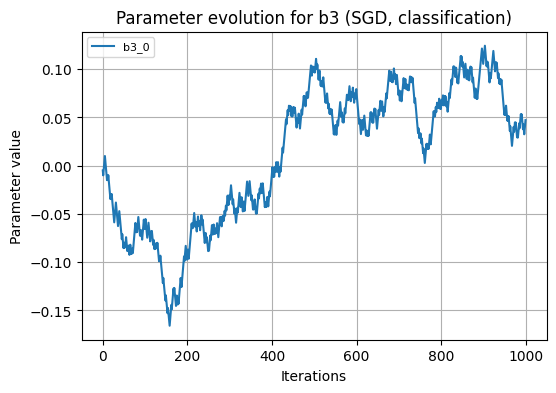

Sample parameter table (every 250 iterations):
   Iteration                               W1                b1  \
0          0    [-0.159, -0.06, 0.001, 0.005]       [-0.0, 0.0]   
1        250  [-0.157, -0.069, 0.002, -0.001]     [-0.0, 0.001]   
2        500  [-0.161, -0.08, -0.001, -0.009]  [-0.001, -0.002]   
3        750  [-0.168, -0.091, -0.008, -0.02]    [-0.001, -0.0]   

                                              W2                       b2  \
0  [-0.045, 0.062, -0.107, -0.014, 0.012, 0.052]     [-0.0, 0.001, 0.001]   
1  [-0.054, 0.077, -0.088, -0.018, 0.018, 0.059]   [-0.006, 0.009, 0.013]   
2  [-0.065, 0.093, -0.071, -0.023, 0.026, 0.068]  [0.009, -0.014, -0.013]   
3  [-0.075, 0.109, -0.055, -0.029, 0.035, 0.077]  [0.003, -0.004, -0.003]   

                        W3        b3    Loss  
0  [0.071, -0.113, -0.153]  [-0.005]  0.6934  
1  [0.078, -0.122, -0.144]  [-0.083]  0.7400  
2  [0.087, -0.134, -0.138]   [0.102]  0.6433  
3  [0.096, -0.146, -0.134]   [0.028]  0.709

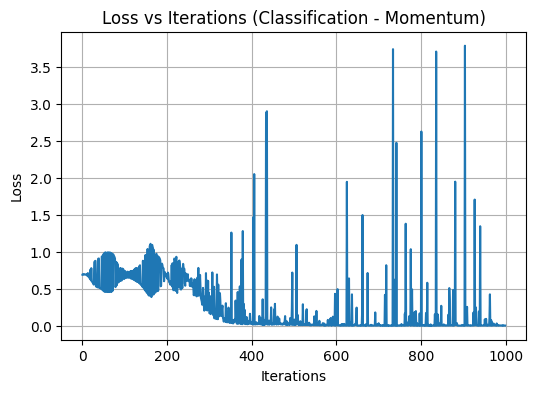

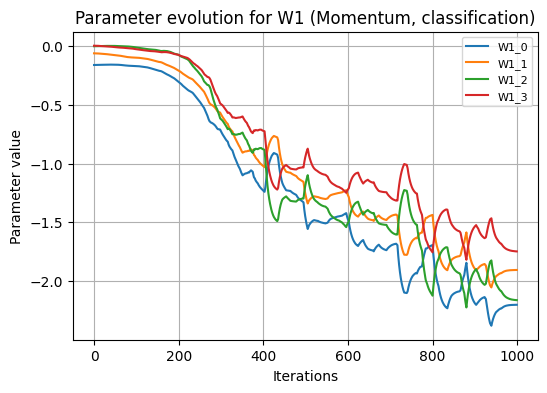

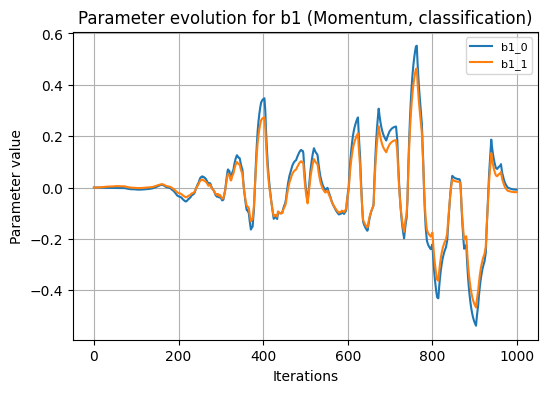

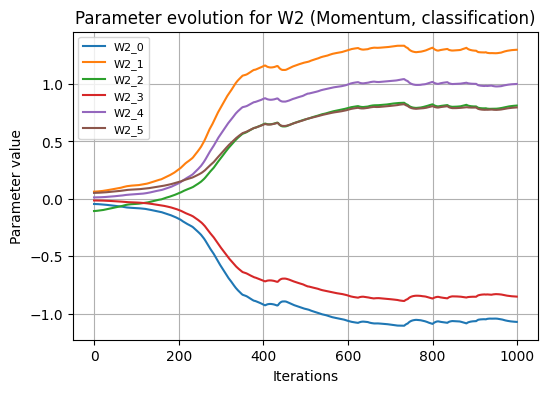

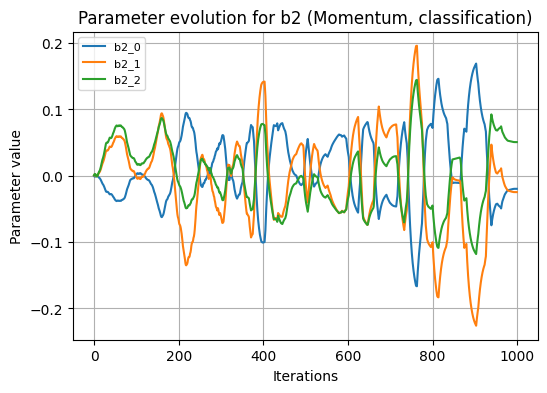

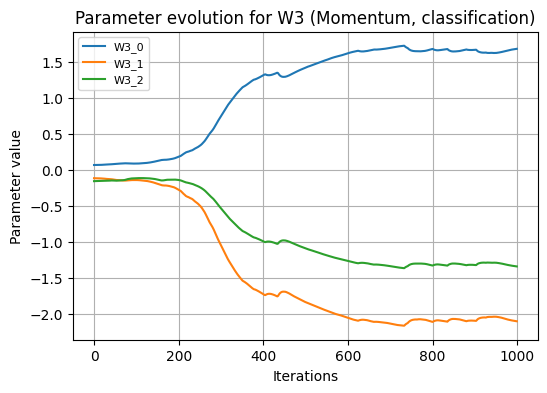

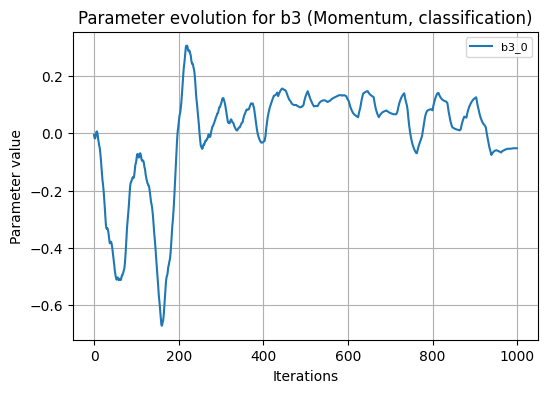

Sample parameter table (every 250 iterations):
   Iteration                                W1               b1  \
0          0     [-0.159, -0.06, 0.001, 0.005]      [-0.0, 0.0]   
1        250  [-0.473, -0.345, -0.237, -0.188]   [0.031, 0.023]   
2        500   [-1.47, -1.269, -1.172, -0.931]  [0.011, -0.007]   
3        750   [-1.976, -1.67, -1.443, -1.189]     [0.37, 0.31]   

                                              W2                       b2  \
0  [-0.045, 0.062, -0.107, -0.014, 0.012, 0.052]     [-0.0, 0.001, 0.001]   
1   [-0.303, 0.438, 0.142, -0.195, 0.276, 0.218]   [-0.004, 0.012, 0.017]   
2    [-0.96, 1.189, 0.693, -0.756, 0.909, 0.693]  [0.033, -0.011, -0.037]   
3   [-1.064, 1.288, 0.799, -0.853, 1.002, 0.791]   [-0.108, 0.129, 0.095]   

                        W3        b3    Loss  
0  [0.071, -0.113, -0.153]  [-0.005]  0.6934  
1  [0.339, -0.492, -0.237]  [-0.011]  0.6063  
2  [1.426, -1.835, -1.089]    [0.13]  0.0298  
3  [1.662, -2.086, -1.306]  [-0.022]  0.012

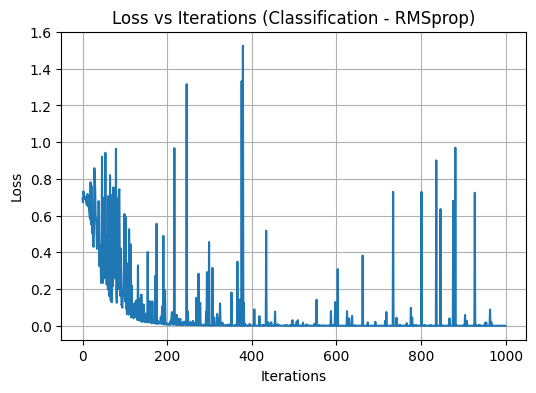

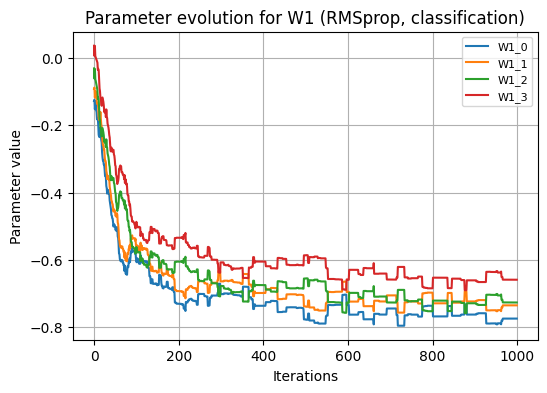

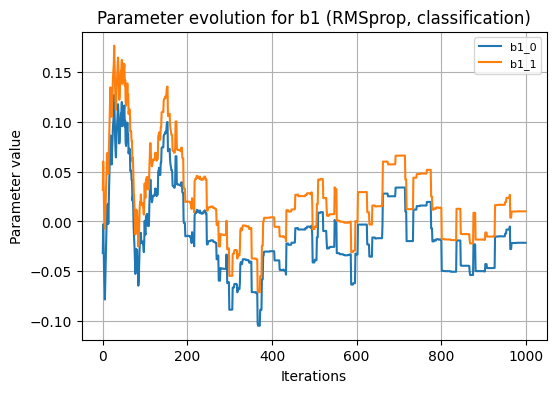

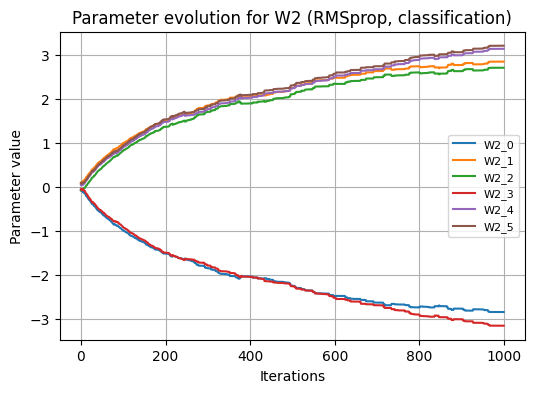

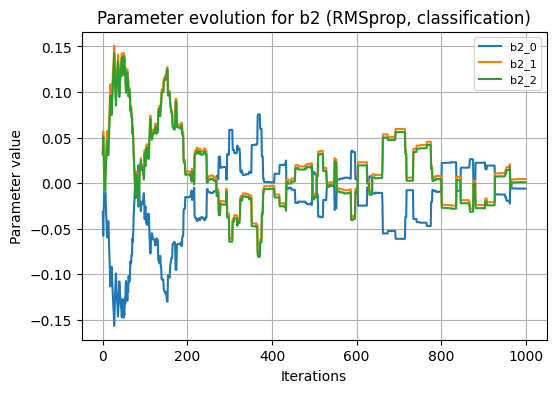

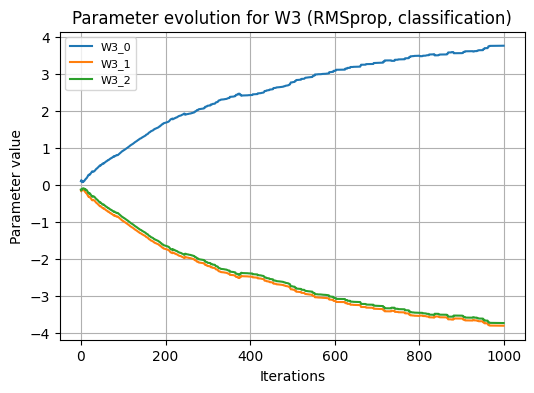

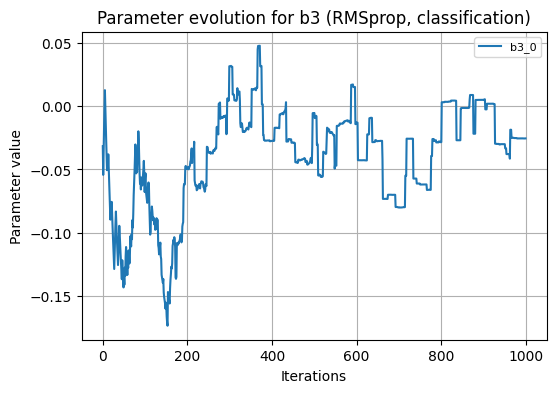

Sample parameter table (every 250 iterations):
   Iteration                                W1                b1  \
0          0   [-0.128, -0.092, -0.031, 0.036]   [-0.032, 0.032]   
1        250  [-0.701, -0.663, -0.662, -0.592]    [-0.02, 0.014]   
2        500  [-0.776, -0.738, -0.655, -0.586]  [-0.041, -0.008]   
3        750  [-0.762, -0.723, -0.722, -0.654]    [0.016, 0.048]   

                                              W2                       b2  \
0  [-0.077, 0.094, -0.075, -0.046, 0.044, 0.083]   [-0.032, 0.032, 0.032]   
1     [-1.657, 1.66, 1.512, -1.645, 1.629, 1.69]    [-0.01, 0.007, 0.004]   
2    [-2.25, 2.254, 2.113, -2.262, 2.246, 2.314]  [0.012, -0.014, -0.018]   
3     [-2.681, 2.685, 2.544, -2.815, 2.8, 2.869]   [-0.044, 0.042, 0.038]   

                        W3        b3    Loss  
0  [0.103, -0.144, -0.122]  [-0.032]  0.6934  
1  [1.919, -1.963, -1.875]  [-0.036]  0.0038  
2  [2.782, -2.828, -2.744]  [-0.005]  0.0004  
3  [3.403, -3.446, -3.362]  [-0.062]  

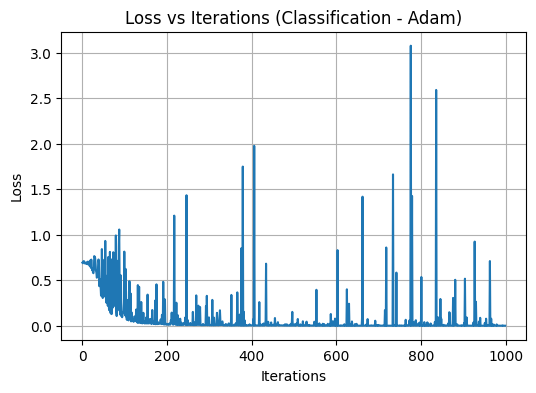

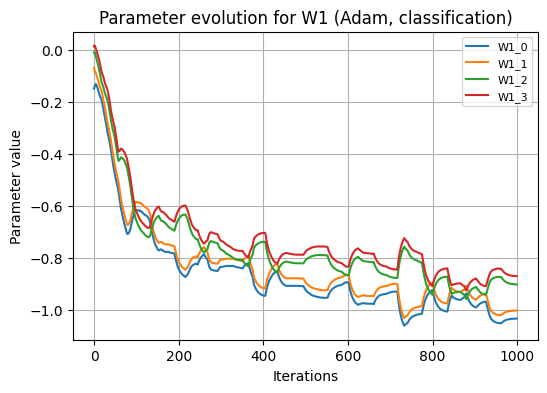

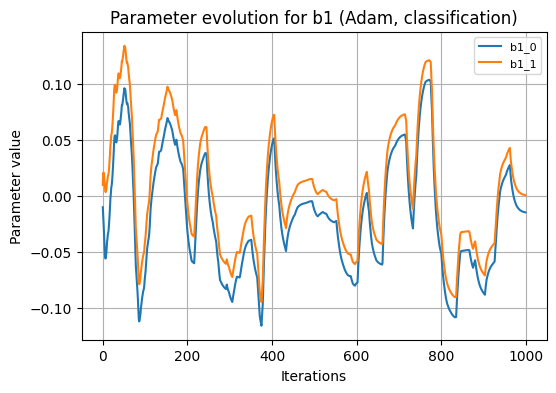

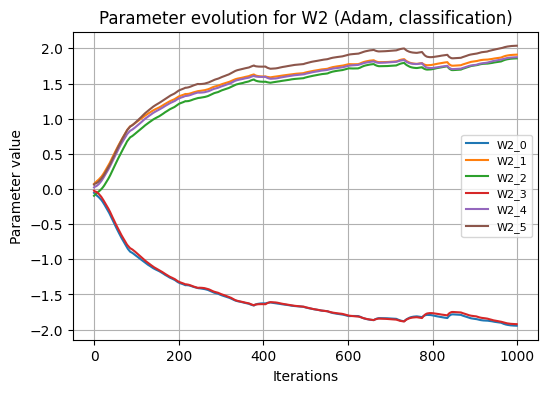

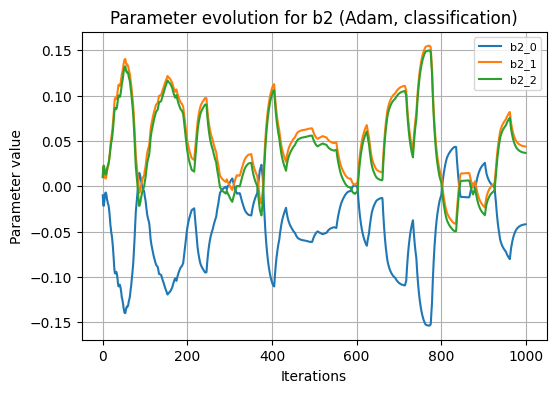

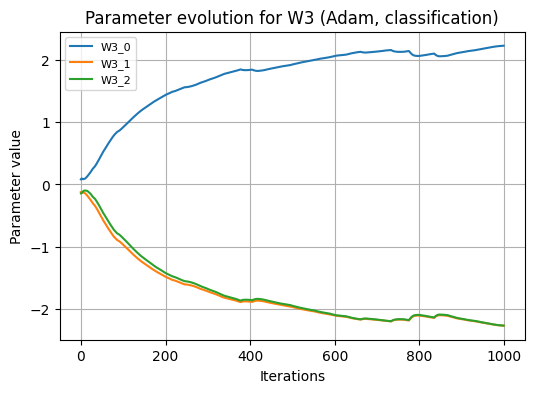

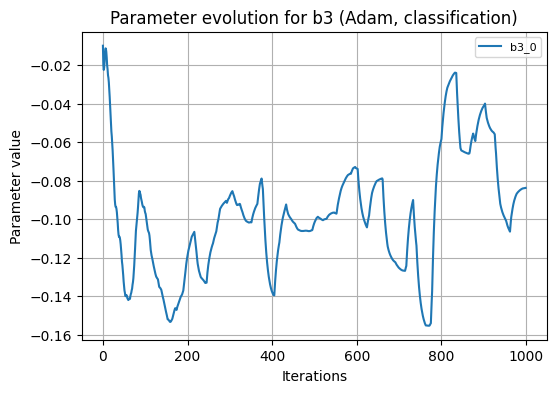

Sample parameter table (every 250 iterations):
   Iteration                                W1               b1  \
0          0    [-0.149, -0.07, -0.009, 0.015]    [-0.01, 0.01]   
1        250   [-0.806, -0.778, -0.754, -0.72]   [0.005, 0.028]   
2        500  [-0.923, -0.894, -0.809, -0.776]  [-0.013, 0.007]   
3        750    [-1.029, -1.0, -0.798, -0.765]   [0.076, 0.093]   

                                              W2                      b2  \
0  [-0.055, 0.072, -0.097, -0.024, 0.022, 0.061]     [-0.01, 0.01, 0.01]   
1    [-1.413, 1.394, 1.297, -1.405, 1.37, 1.492]  [-0.069, 0.072, 0.063]   
2   [-1.686, 1.657, 1.586, -1.683, 1.638, 1.786]  [-0.055, 0.057, 0.049]   
3    [-1.822, 1.789, 1.73, -1.832, 1.783, 1.944]   [-0.129, 0.13, 0.125]   

                        W3        b3    Loss  
0  [0.081, -0.122, -0.143]   [-0.01]  0.6934  
1  [1.561, -1.606, -1.555]  [-0.122]  0.0122  
2  [1.925, -1.967, -1.947]  [-0.102]  0.0061  
3  [2.127, -2.169, -2.162]  [-0.142]  0.0048  



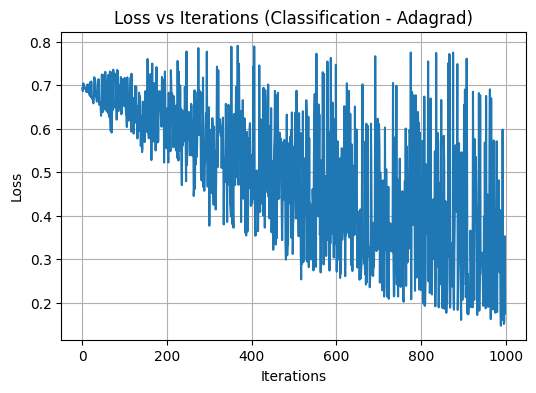

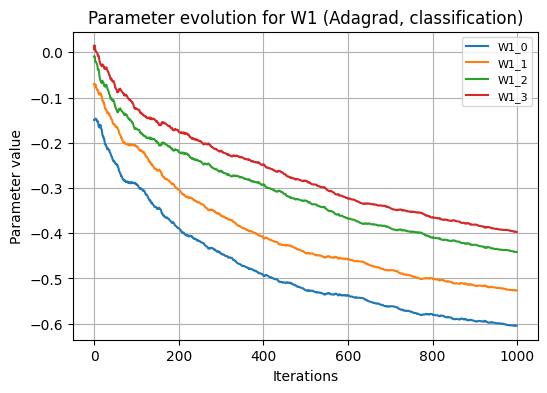

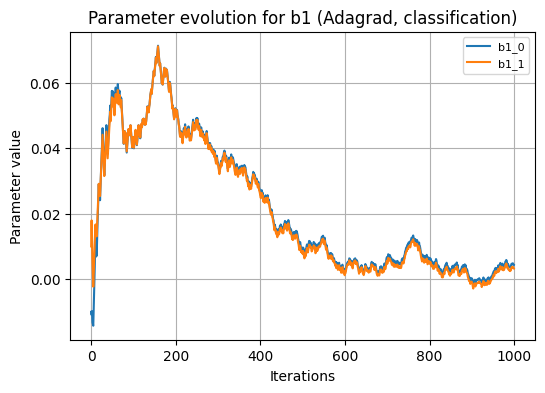

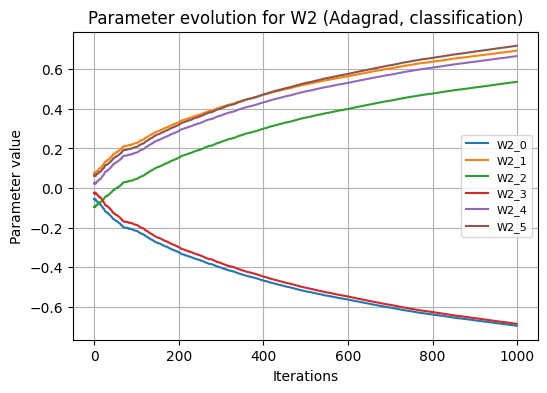

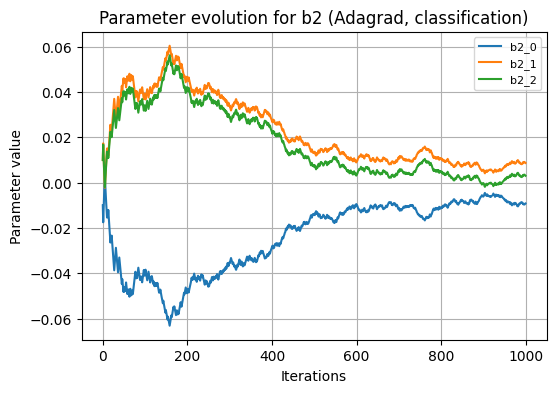

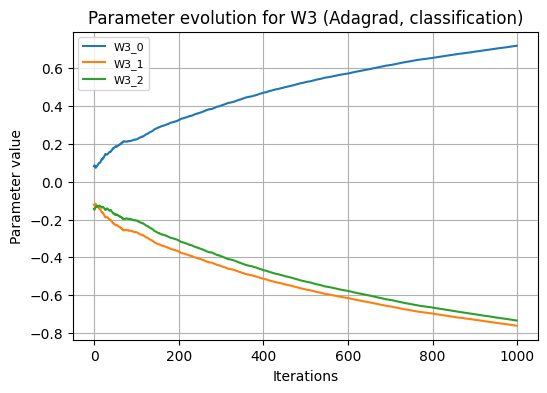

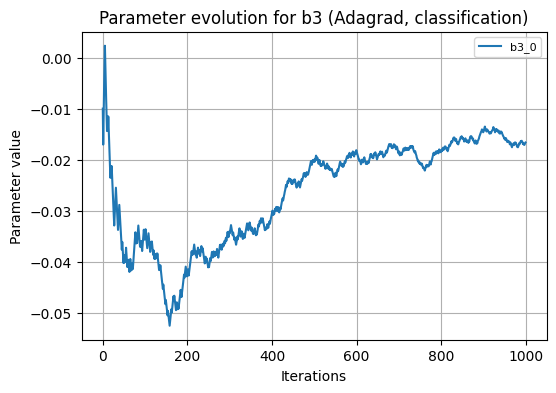

Sample parameter table (every 250 iterations):
   Iteration                                W1              b1  \
0          0    [-0.149, -0.07, -0.009, 0.015]   [-0.01, 0.01]   
1        250  [-0.418, -0.333, -0.241, -0.197]  [0.048, 0.048]   
2        500  [-0.526, -0.444, -0.328, -0.284]  [0.009, 0.008]   
3        750  [-0.574, -0.494, -0.396, -0.352]   [0.011, 0.01]   

                                              W2                      b2  \
0  [-0.055, 0.072, -0.097, -0.024, 0.022, 0.061]     [-0.01, 0.01, 0.01]   
1     [-0.364, 0.37, 0.193, -0.34, 0.328, 0.361]  [-0.045, 0.043, 0.039]   
2   [-0.522, 0.524, 0.356, -0.504, 0.488, 0.531]  [-0.014, 0.013, 0.007]   
3   [-0.623, 0.623, 0.461, -0.611, 0.592, 0.641]  [-0.015, 0.014, 0.009]   

                        W3        b3    Loss  
0  [0.081, -0.122, -0.143]   [-0.01]  0.6934  
1  [0.365, -0.408, -0.353]  [-0.041]  0.6385  
2   [0.527, -0.57, -0.528]   [-0.02]  0.5590  
3   [0.638, -0.68, -0.648]  [-0.021]  0.5313  

=== R

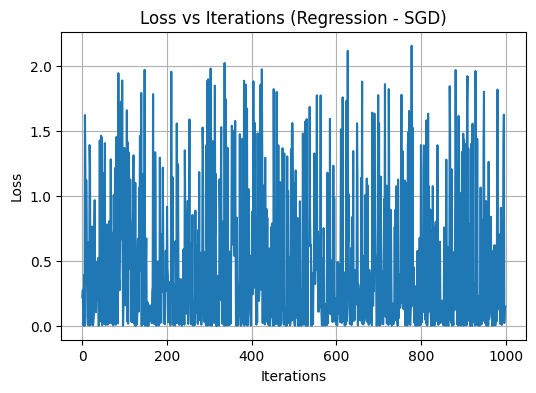

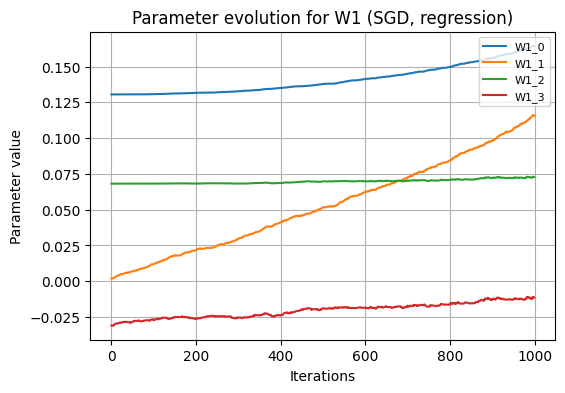

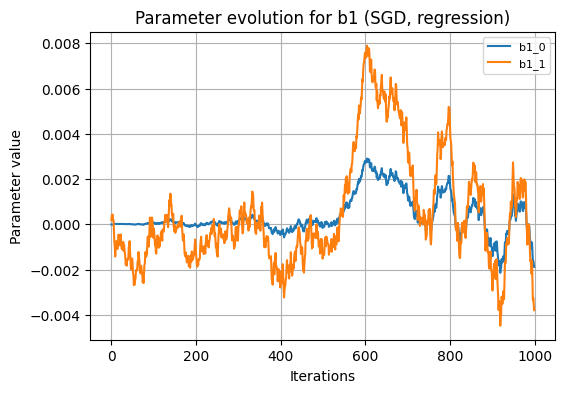

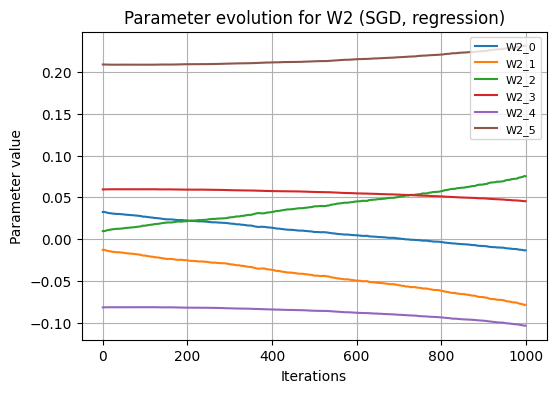

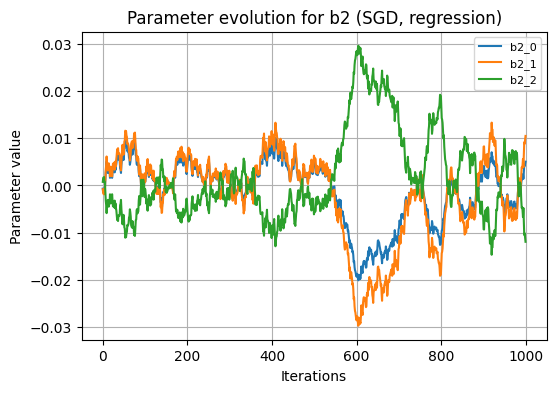

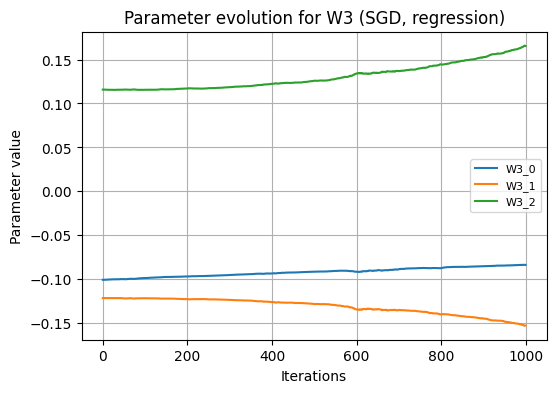

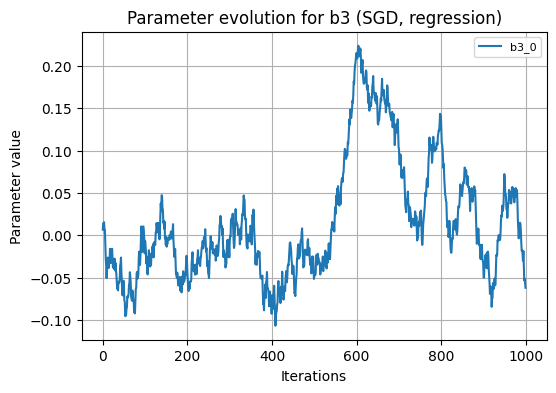

Sample parameter table (every 250 iterations):
   Iteration                             W1              b1  \
0          0  [0.131, 0.002, 0.068, -0.031]     [-0.0, 0.0]   
1        250  [0.132, 0.025, 0.068, -0.025]  [-0.0, -0.001]   
2        500   [0.138, 0.052, 0.07, -0.019]  [-0.0, -0.001]   
3        750   [0.147, 0.079, 0.07, -0.018]    [0.0, 0.001]   

                                             W2                       b2  \
0    [0.032, -0.013, 0.01, 0.06, -0.082, 0.209]  [-0.001, -0.001, 0.001]   
1   [0.021, -0.028, 0.024, 0.059, -0.082, 0.21]   [0.005, 0.006, -0.005]   
2  [0.009, -0.044, 0.039, 0.056, -0.086, 0.213]   [0.005, 0.006, -0.006]   
3  [-0.001, -0.059, 0.054, 0.052, -0.092, 0.22]  [-0.002, -0.003, 0.003]   

                        W3        b3    Loss  
0  [-0.101, -0.121, 0.116]   [0.007]  0.2189  
1  [-0.096, -0.123, 0.117]  [-0.046]  0.0134  
2  [-0.091, -0.128, 0.126]  [-0.048]  0.0615  
3   [-0.087, -0.137, 0.14]   [0.028]  0.3944  

Training with Moment

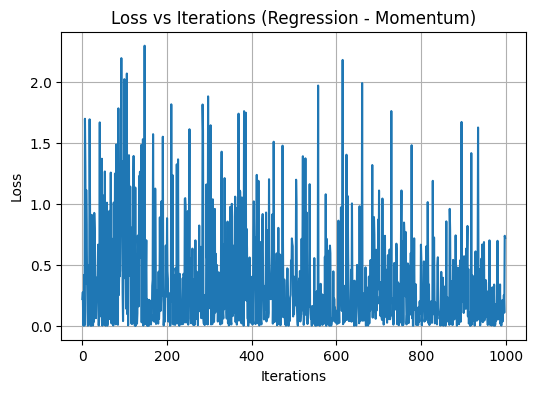

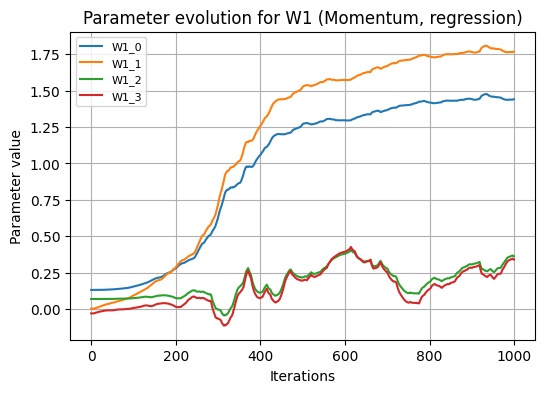

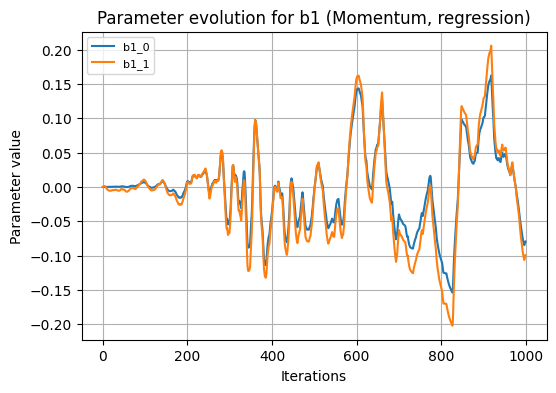

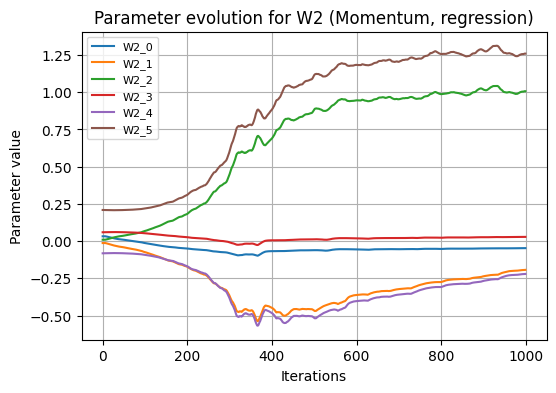

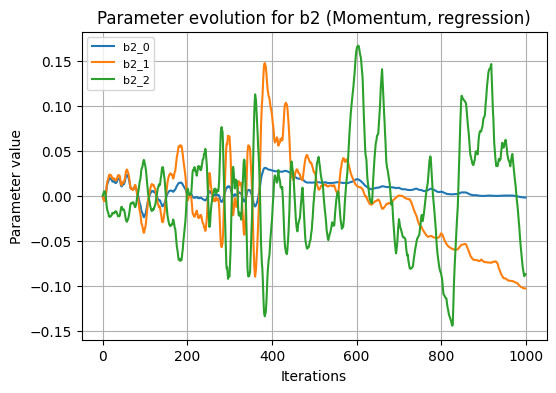

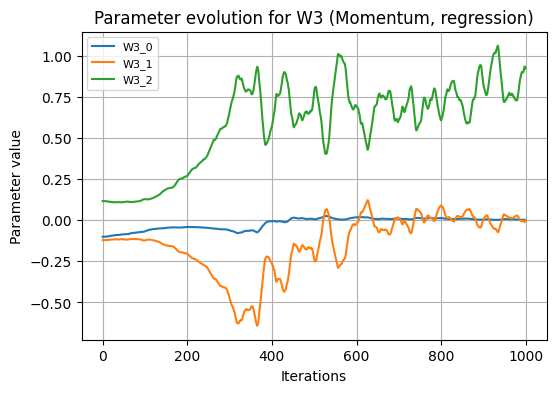

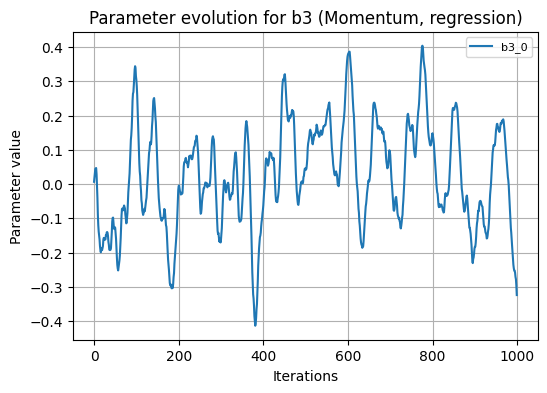

Sample parameter table (every 250 iterations):
   Iteration                             W1                b1  \
0          0  [0.131, 0.002, 0.068, -0.031]       [-0.0, 0.0]   
1        250   [0.382, 0.421, 0.119, 0.075]  [-0.003, -0.007]   
2        500   [1.271, 1.527, 0.217, 0.195]  [-0.003, -0.006]   
3        750   [1.402, 1.713, 0.108, 0.043]  [-0.052, -0.081]   

                                              W2                       b2  \
0     [0.032, -0.013, 0.01, 0.06, -0.082, 0.209]  [-0.001, -0.001, 0.001]   
1  [-0.063, -0.243, 0.278, 0.014, -0.237, 0.402]   [0.003, 0.011, -0.015]   
2  [-0.061, -0.468, 0.885, 0.012, -0.517, 1.115]    [0.015, 0.026, 0.003]   
3  [-0.053, -0.294, 0.958, 0.022, -0.329, 1.226]  [0.007, -0.033, -0.034]   

                        W3        b3    Loss  
0  [-0.101, -0.121, 0.116]   [0.007]  0.2189  
1    [-0.047, -0.3, 0.409]  [-0.035]  0.0088  
2   [0.006, -0.237, 0.782]   [0.046]  0.0953  
3     [0.013, 0.05, 0.593]   [0.162]  0.0242  

Train

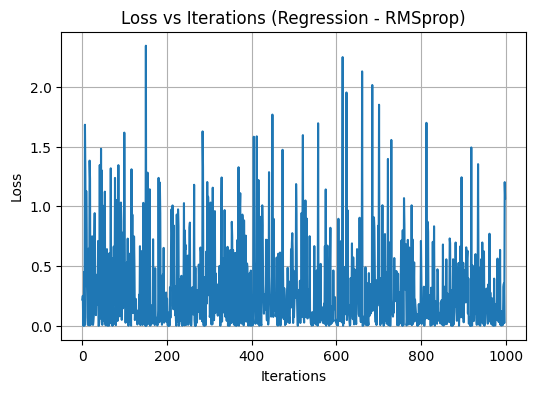

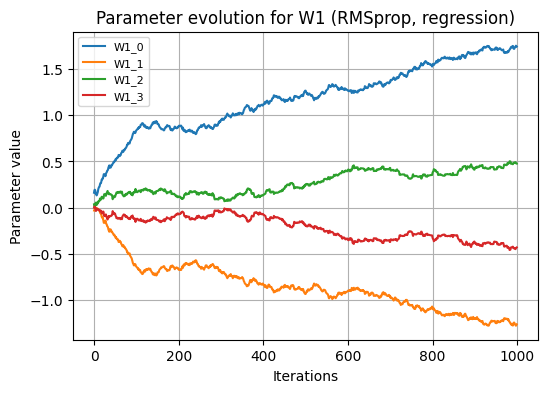

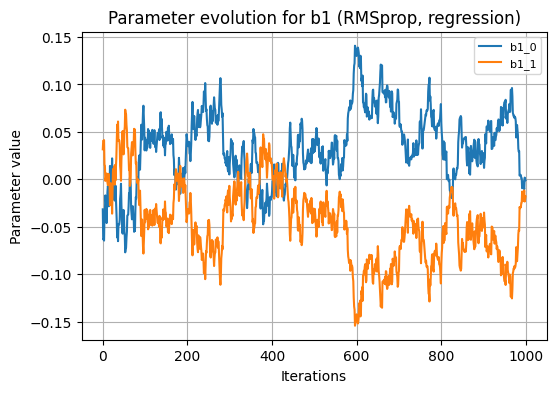

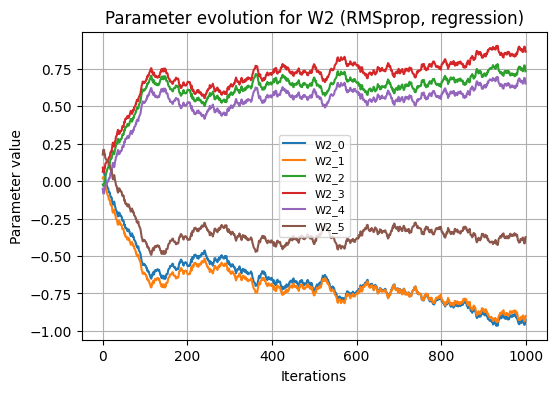

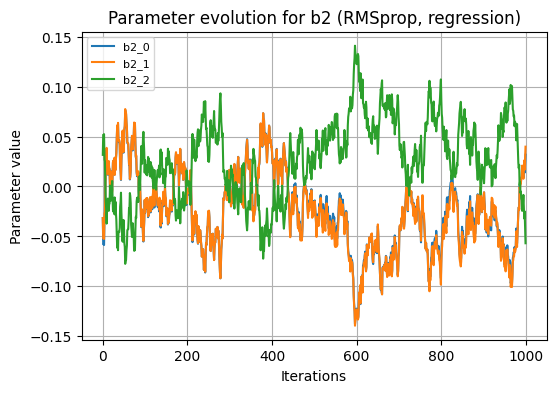

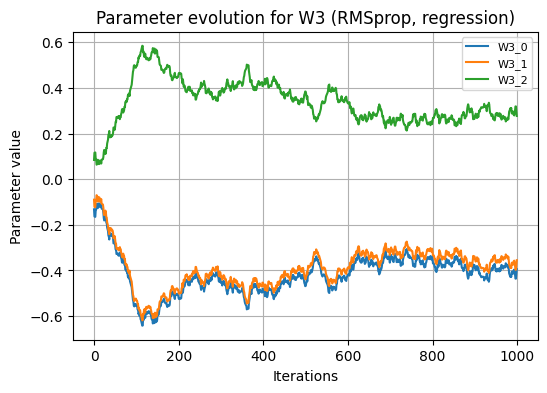

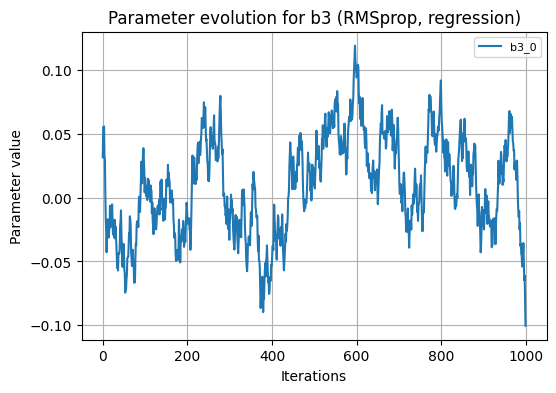

Sample parameter table (every 250 iterations):
   Iteration                              W1               b1  \
0          0    [0.162, -0.03, 0.037, 0.001]  [-0.032, 0.032]   
1        250   [0.87, -0.638, 0.157, -0.102]  [0.043, -0.045]   
2        500  [1.264, -0.931, 0.243, -0.186]  [0.038, -0.039]   
3        750  [1.477, -1.052, 0.317, -0.258]  [0.061, -0.076]   

                                              W2                       b2  \
0    [0.064, 0.019, -0.022, 0.091, -0.05, 0.178]  [-0.032, -0.032, 0.032]   
1  [-0.529, -0.581, 0.564, 0.615, 0.476, -0.334]  [-0.027, -0.027, 0.027]   
2   [-0.738, -0.763, 0.692, 0.781, 0.614, -0.42]  [-0.022, -0.023, 0.025]   
3    [-0.754, -0.753, 0.636, 0.74, 0.55, -0.315]  [-0.045, -0.044, 0.042]   

                        W3       b3    Loss  
0   [-0.132, -0.09, 0.084]  [0.032]  0.2189  
1  [-0.457, -0.432, 0.394]  [0.015]  0.0081  
2  [-0.468, -0.438, 0.384]  [0.015]  0.0717  
3  [-0.347, -0.313, 0.251]  [0.011]  0.0172  

Training w

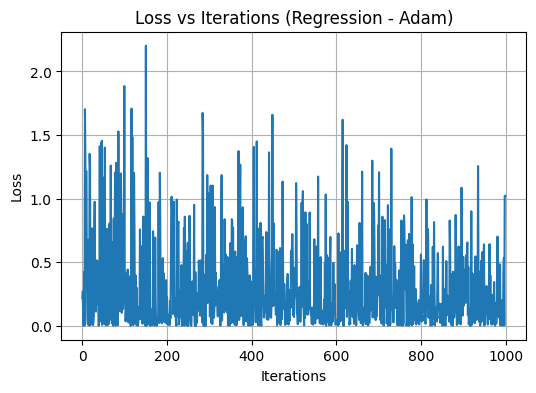

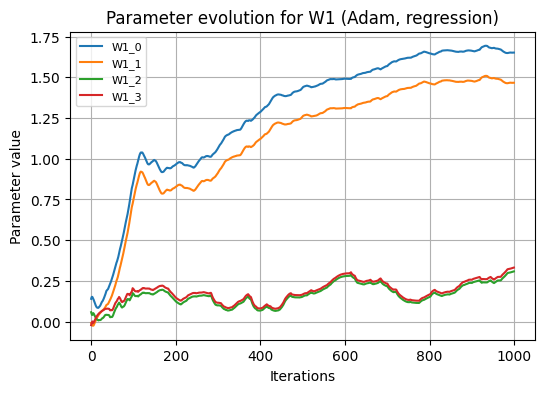

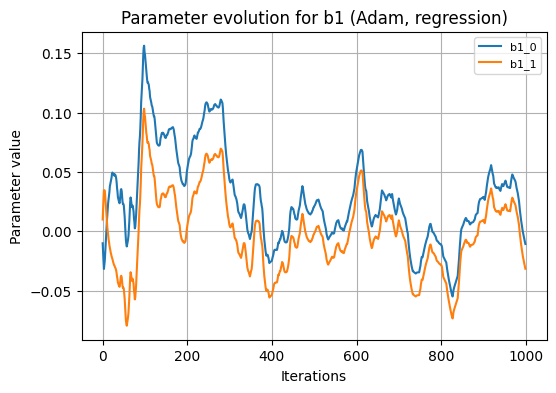

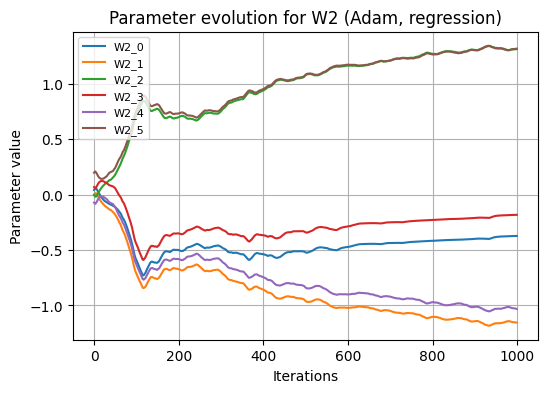

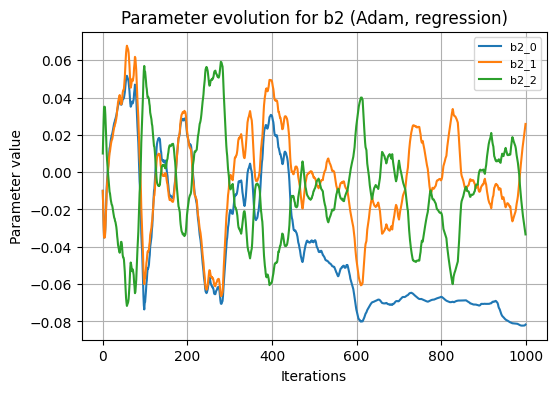

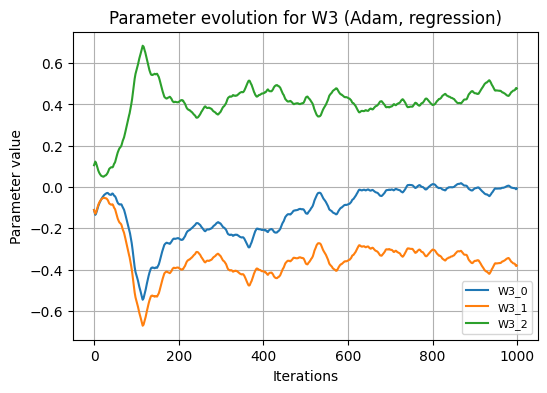

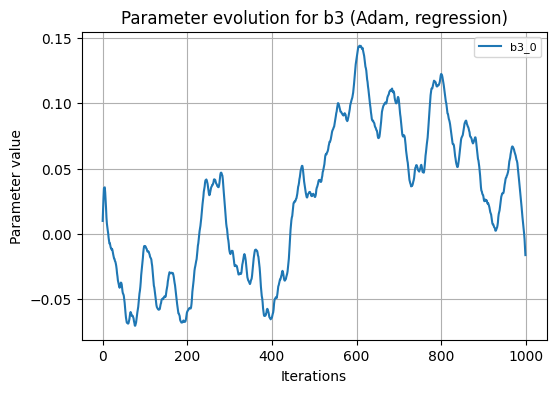

Sample parameter table (every 250 iterations):
   Iteration                              W1               b1  \
0          0  [0.141, -0.008, 0.058, -0.021]    [-0.01, 0.01]   
1        250    [0.969, 0.825, 0.155, 0.175]   [0.104, 0.061]   
2        500    [1.438, 1.261, 0.154, 0.168]  [0.021, -0.002]   
3        750      [1.62, 1.435, 0.12, 0.134]  [-0.031, -0.05]   

                                               W2                        b2  \
0      [0.042, -0.003, -0.0, 0.07, -0.072, 0.199]      [-0.01, -0.01, 0.01]   
1   [-0.455, -0.65, 0.693, -0.298, -0.551, 0.718]    [-0.059, -0.056, 0.05]   
2     [-0.521, -0.961, 1.08, -0.34, -0.84, 1.085]  [-0.037, -0.003, -0.009]   
3  [-0.427, -1.071, 1.237, -0.239, -0.939, 1.232]   [-0.068, 0.021, -0.044]   

                        W3       b3    Loss  
0  [-0.111, -0.111, 0.106]   [0.01]  0.2189  
1   [-0.183, -0.326, 0.35]  [0.033]  0.0000  
2  [-0.125, -0.368, 0.431]   [0.03]  0.0681  
3    [0.01, -0.299, 0.389]   [0.05]  0.0217  



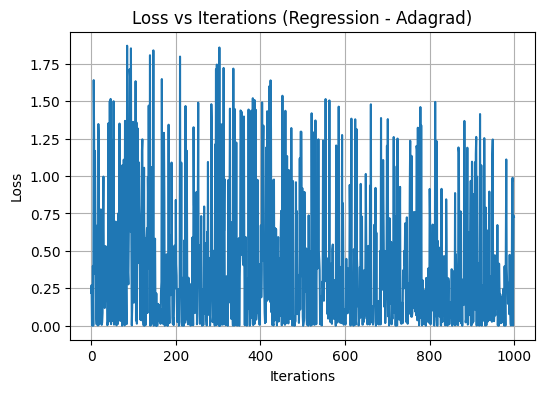

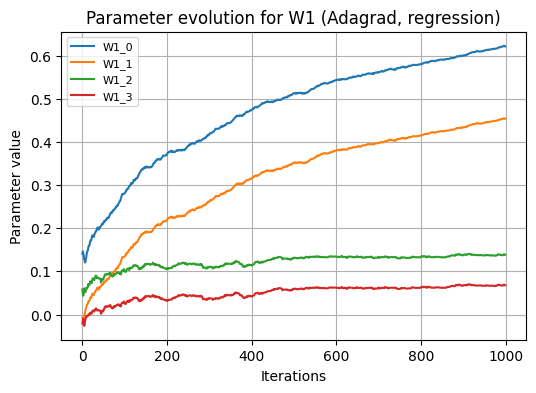

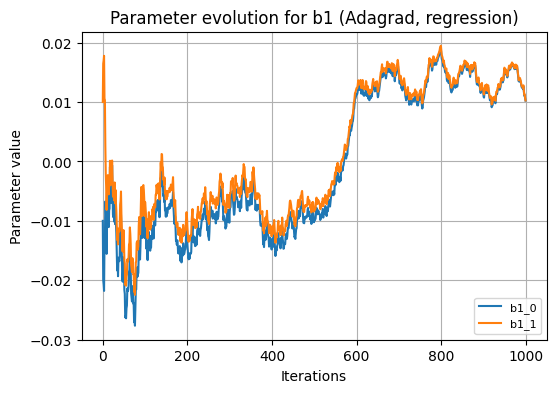

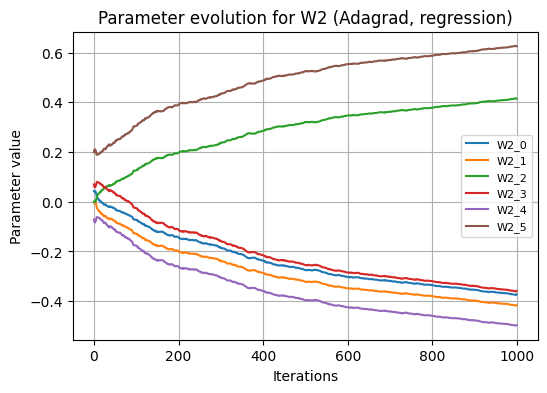

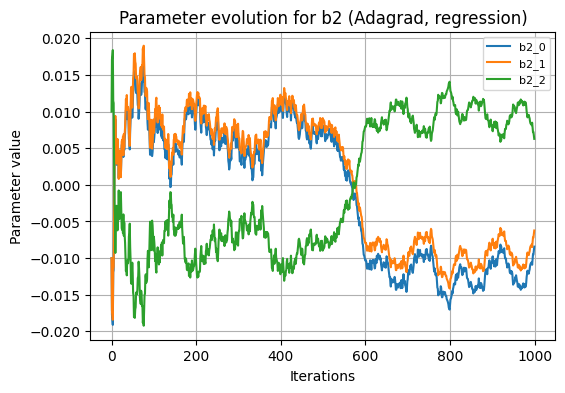

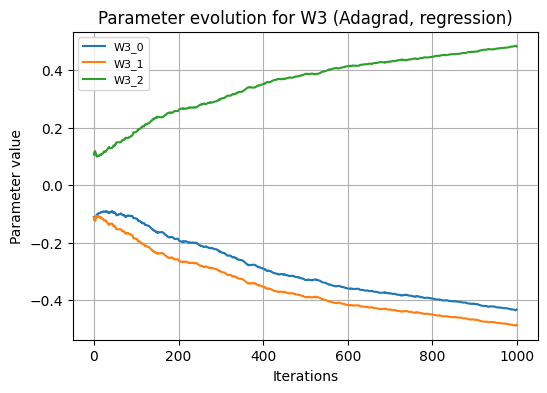

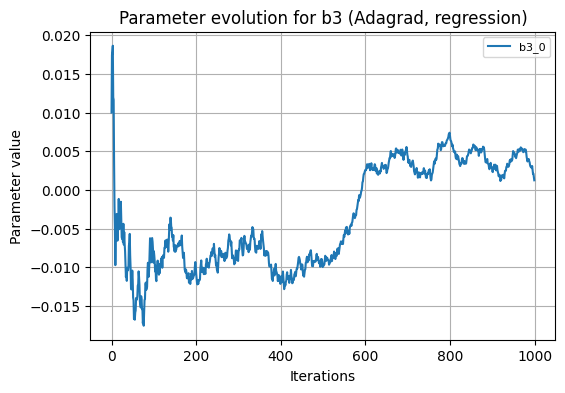

Sample parameter table (every 250 iterations):
   Iteration                              W1               b1  \
0          0  [0.141, -0.008, 0.058, -0.021]    [-0.01, 0.01]   
1        250     [0.39, 0.237, 0.117, 0.043]  [-0.013, -0.01]   
2        500     [0.513, 0.352, 0.131, 0.06]  [-0.01, -0.008]   
3        750     [0.572, 0.407, 0.13, 0.059]   [0.011, 0.012]   

                                               W2                      b2  \
0      [0.042, -0.003, -0.0, 0.07, -0.072, 0.199]    [-0.01, -0.01, 0.01]   
1   [-0.162, -0.217, 0.215, -0.133, -0.281, 0.41]    [0.009, 0.01, -0.01]   
2  [-0.275, -0.322, 0.321, -0.255, -0.397, 0.525]  [0.008, 0.009, -0.009]   
3    [-0.327, -0.372, 0.37, -0.311, -0.45, 0.579]  [-0.01, -0.008, 0.008]   

                        W3       b3    Loss  
0  [-0.111, -0.111, 0.106]   [0.01]  0.2189  
1  [-0.209, -0.278, 0.278]  [-0.01]  0.0094  
2  [-0.329, -0.389, 0.387]  [-0.01]  0.0627  
3  [-0.385, -0.441, 0.438]  [0.003]  0.1139  


In [82]:
# -------------------------------
# Run Experiments for Different Tasks and Optimizers
# -------------------------------
# (For demonstration, we run one training session for classification and one for regression.)

optimizers = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad']

# --- Experiment A: Classification ---
print("=== Classification Task ===")
history_class = {}
final_params_class = {}
for opt in optimizers:
    print(f"\nTraining with {opt} optimizer (Classification)...")
    hist, params, X_class, y_class = train_network(task='classification', optimizer=opt, epochs=1000, lr=0.01)
    history_class[opt] = hist
    final_params_class[opt] = params
    # Plot loss curve and parameter evolution
    plot_loss(hist, opt, task='classification')
    plot_parameter_histories(hist, opt, task='classification')
    # Optionally, display a sample table for a few iterations:
    table = display_parameter_table(hist, iteration_indices=range(0, 1000, 250))
    print("Sample parameter table (every 250 iterations):")
    print(table)

# --- Experiment B: Regression ---
print("\n=== Regression Task ===")
history_reg = {}
final_params_reg = {}
for opt in optimizers:
    print(f"\nTraining with {opt} optimizer (Regression)...")
    hist, params, X_reg, y_reg = train_network(task='regression', optimizer=opt, epochs=1000, lr=0.01)
    history_reg[opt] = hist
    final_params_reg[opt] = params
    # Plot loss curve and parameter evolution
    plot_loss(hist, opt, task='regression')
    plot_parameter_histories(hist, opt, task='regression')
    # Optionally, display a sample table for a few iterations:
    table = display_parameter_table(hist, iteration_indices=range(0, 1000, 250))
    print("Sample parameter table (every 250 iterations):")
    print(table)
